In [47]:
%matplotlib notebook
import numpy as np
import scipy.io as io
import sounddevice as sd
import scipy.signal as signal
import matplotlib.pyplot as pyplot
import numpy.fft as fft
import random
import numpy.random as npRand
import time
import itertools as it
import collections as coll

Pomocne funkcije:

In [56]:
def spectrogram(x, fs, win, winLen, overlap):
    f, t, Xft = signal.stft(x, fs, win, winLen, overlap)
    pyplot.figure()
    pyplot.pcolormesh(1000 * t, f, np.abs(Xft))
    
def loadMatSound(filename):
    return io.loadmat(filename)[filename.replace(".mat", "")][:, 0]

def genTones(tones, duration):
    Fs = 8000
    samples = round(Fs * duration)
    n = np.arange(samples)
    result = np.zeros(samples)
    
    for tone in tones:
        result += np.cos(2 * np.pi * tone * n / Fs)
        
    return result

replaceZeroes = np.vectorize(lambda t: 10 ** (-10) if t == 0 else t)

def plot_spectrum_t(x, fs, win, winLen, overlap, tPoint):
    f, t, Xft = signal.stft(x, fs, win, winLen, overlap)
    
    timeIndex = None
    highFreqI = None
    lowFreqI = None
    
    for i, ti in enumerate(t):
        if tPoint <= ti:
            timeIndex = i
            break
            
    for i, fi in enumerate(f):
        
        if lowFreqI is None and fi >= 650:
            lowFreqI = i
            
        if highFreqI is None and fi >= 1650:
            highFreqI = i
        
        if lowFreqI is not None and highFreqI is not None:
            break
    
    timeIndex = timeIndex if t[timeIndex] - tPoint < tPoint - t[timeIndex - 1] \
    else timeIndex - 1
     
    pyplot.figure()
    pyplot.title(f"t = {tPoint}")
    pyplot.plot(f[lowFreqI:highFreqI], np.abs(Xft[lowFreqI:highFreqI, timeIndex]))
            
dtmfTable = {
    1:(697, 1209),
    2:(697, 1336),
    3:(697, 1477),
    "A":(697, 1633),
    4:(770, 1209),
    5:(770, 1336),
    6:(770, 1477),
    "B":(770, 1633),
    7:(852, 1209),
    8:(852, 1336),
    9:(852, 1477),
    "C":(852, 1633),
    "*":(941, 1209),
    0:(941, 1336),
    "#":(941, 1477),  
    "D":(941, 1633)
}

def dtmfEncoder(keys, toneDuration, silenceDuration):
    Fs = 8000
    result = None
    silence = np.zeros(round(Fs * silenceDuration))
    for key in keys:
        t = genTones(dtmfTable[key], toneDuration)
        if result is None:
            result = t
        else:
            result = np.concatenate((result, silence, t))
            
            
    return result



def benchmark(dtmf, n, noiseVariance = None ):
    decodedCount = 0 # Num of succesful decoding
    toDecode = n
    decodeTime = 0
    for n in range(toDecode):
        seq = random.choices(list(dtmfTable.keys()), k = 6)
        toneDuration = random.uniform(0.04, 0.1)
        encodedSeq = dtmfEncoder(seq, toneDuration, 0.04)
        if noiseVariance is not None:
            encodedSeq = encodedSeq + npRand.normal(0, noiseVariance ** 0.5, len(encodedSeq))
        startTime = time.perf_counter_ns()
        decodedSeq = dtmf.decode(encodedSeq)
        endTime = time.perf_counter_ns()
        decodeTime += endTime - startTime
        if seq == decodedSeq:
            decodedCount += 1
    print(f"Broj uspjesnih dekodovanja: {decodedCount}")
    print(f"Broj neuspjesnih dekodovanja {toDecode - decodedCount}")
    print(f"Procenat uspjesnosti: {decodedCount * 100 / toDecode}")
    decodePerSec = decodedCount * 10 ** 9 / decodeTime
    print(f"Broj dekodovanja u sekundi: {round(decodePerSec)}")
    print(f"Trajanje jednog dekodovanja(u ms): {1000 / decodePerSec}")
    

<IPython.core.display.Javascript object>


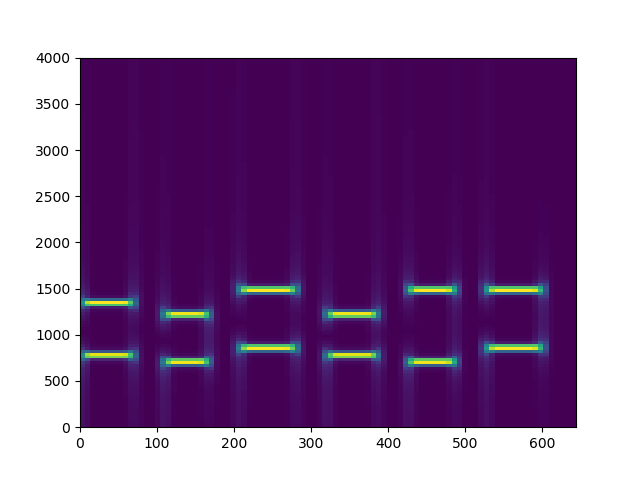

<IPython.core.display.Javascript object>


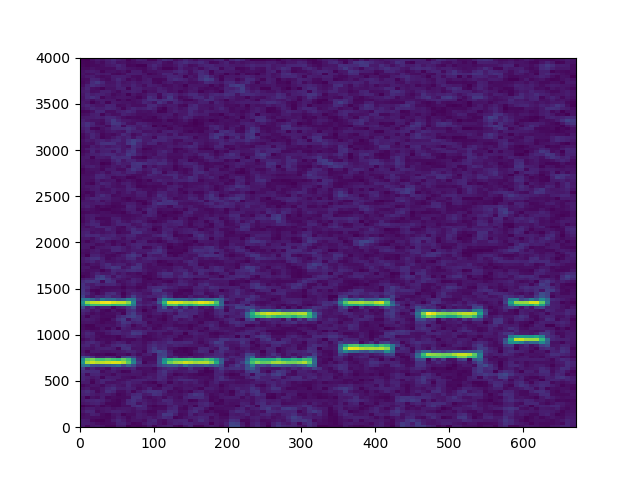

<IPython.core.display.Javascript object>


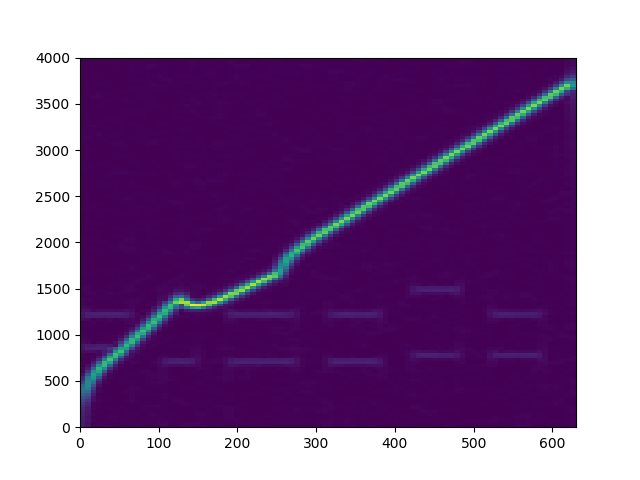

In [51]:
dtmf1 = loadMatSound("dtmf1.mat") # 519439
dtmf2 = loadMatSound("dtmf2.mat") # 221840
dtmf3 = loadMatSound("dtmf3.mat") # 721164
spectrogram(dtmf1, 8000, "hann", 256, 200)
spectrogram(dtmf2, 8000, "hann", 256, 200)
spectrogram(dtmf3, 8000, "hann", 256, 200)

Sa slika se mogu procitati vrijednosti
1. 519439
2. 221840
3. 721164

U projektu su implementirana tri vrste dekodera
Sva tri dekodera se inicijalizuju brojem koji oznacava minimalno trajanje tona

Prvi dekoder je implementiran u klasi DTMF

### Princip rada:

Dekoder funkcionise tako sto sto prolazi kroz niz spektara STFT matrice. 
Za svaki spektar se odredi koji je taster pritisnut, te se prepoznaje da li je odgovarajuci ton za pritisnuti taster traje neko vrijeme. 


Odredjivanje koji je taster pritisnut za jedan spektar se vrsi tako sto se ona uporedi sa spektrom tonova svih mogucih tastera.
Poredjenje spektara je realizovano kao skalarni proizvod. Rezultat skalarnog proizvoda je u ovom slucaju koeficijent slicnosti.
Zatim se koeficijent slicnosti poredi sa maksimalnim koeficijentom slicnosti. Ako je koeficijent slicnosti veci od 50% maksimalnog koeficijenta slicnosti za neki taster, kazemo da je taj taster pritisnut.

Ovaj proces se ponavlja sve dok ne naidjemo na tisinu, tada provjeravamo da li je ton tastera trajao odredjeno minimalno vrijeme. Ako jeste taster registrujemo kao pritisnut.


Ovaj dekoder zahtjeva inicijalizaciju, u kodu za inicijalizaciju se za svaki moguci taster generise ton.
Zatim se vrsi FFT tog tona i radi se skalarni proizvod rezultata FFT-a sa samim sobom. Dobijeni broj predstavlja maksimalnu slicnost.

Parametri STFT-a su odabrani s ciljem da se dobije kompromis izmedju rezolucije u frekvenciji i rezolucije u vremenu.
Vise se tezilo da se dobije bolja rezolucija u frekvenciji, stoga je odabran pravougani prozor.

### Prednosti:
- Dekoder je jednostavan za implementaciju zbog jednostavnosti ideje
- 100% uspjesnost dekodovanja na 10000 uzoraka (6 tastera po uzorku)
- 100% uspjesnost dekodovanja na 10000 uzoraka (6 tastera po uzorku) za slucaj Gausovog suma varijanse 0.5477
- Nezavisnost od trajanja tisine prije i poslije korisnog signala
- Nezavisnost od trajanja tona za neki taster (taster ipak mora biti pritisnut neko minimalno vrijeme)

### Nedostaci
- Dekodovanje tonova sa interferencijom daje pogresne rezultate
- Prostorna slozenost (16 x 256 x sizeof(float) == 16kb, diskutabilno za danasnje vrijeme, moglo bi se izbjeci tako sto se ne vrsi poredjenje spektra skalarni proizvodom uopste nego se uocavaju "peakovi" na neki drugi nacin)
- Potreba da se vrsi poredjenje spektra sa spektrima svim mogucim tonovima (optimizovano u drugom dekoderu)


In [8]:
class DTMF:
    
    dtmfTable = {
    1:(697, 1209),
    2:(697, 1336),
    3:(697, 1477),
    "A":(697, 1633),
    4:(770, 1209),
    5:(770, 1336),
    6:(770, 1477),
    "B":(770, 1633),
    7:(852, 1209),
    8:(852, 1336),
    9:(852, 1477),
    "C":(852, 1633),
    "*":(941, 1209),
    0:(941, 1336),
    "#":(941, 1477),  
    "D":(941, 1633)
    }
    
    def __init__(self, minToneDuration = 0.04):
        self._keys = {}
        self._minToneDuration = minToneDuration
        for key in DTMF.dtmfTable:
            toneFft = fft.rfft(DTMF.genToneKey(DTMF.dtmfTable[key], 256), 256)
            toneFft = np.abs(toneFft) / np.amax(np.abs(toneFft))
            maxSim  = np.dot(toneFft, toneFft)
            self._keys[key] = (toneFft, maxSim) 
    
    def decode(self, x):
        freq, time, Zxx = signal.stft(x, 8000, "boxcar", 256, 128)
        keys = []
        timeAppeared = None
        lastKey = None
        Zxx = (np.abs(Zxx) / np.amax(np.abs(Zxx))).T
        for fftColumn, t in zip(Zxx, time):
            currKey = self.getKeyForFFT(fftColumn)
            if lastKey is None and currKey is not None:
                timeAppeared = t
                lastKey = currKey
            elif lastKey != currKey:
                if t - timeAppeared > self._minToneDuration:
                    keys.append(lastKey)
                lastKey = currKey
                timeAppeared = t
                
        if lastKey != None and time[-1] - timeAppeared > self._minToneDuration:
            keys.append(lastKey)
            
        return keys
            
    def getKeyForFFT(self, fftColumn):
        similarity = {}
        for key, fftSimPair in self._keys.items():
            similarity[key] = np.dot(fftColumn, fftSimPair[0])
            
        result = sorted(similarity.items(), key = lambda keyValue: keyValue[1], reverse = True)      
        decodedKey, sim = result[0][0], result[0][1]        
        return decodedKey if sim > 0.5 * self._keys[decodedKey][1] else None
                  
    @staticmethod
    def genToneKey(freqs, samples):
        Fs = 8000
        n = np.arange(samples)
        result = np.zeros(samples)
    
        for freq in freqs:
             result += np.cos(2 * np.pi * freq * n / Fs)
        
        return result
    

In [57]:
decoder = DTMF(0.03)
print(decoder.decode(dtmf1))
print(decoder.decode(dtmf2))
benchmark(DTMF(0.03), 10000)
benchmark(DTMF(0.03), 10000, 0.5477)

[5, 1, 9, 4, 3, 9]
[2, 2, 1, 8, 4, 0]
Broj uspjesnih dekodovanja: 1000
Broj neuspjesnih dekodovanja 0
Procenat uspjesnosti: 100.0
Broj dekodovanja u sekundi: 602
Trajanje jednog dekodovanja(u ms): 1.6624828999999999
Broj uspjesnih dekodovanja: 1000
Broj neuspjesnih dekodovanja 0
Procenat uspjesnosti: 100.0
Broj dekodovanja u sekundi: 647
Trajanje jednog dekodovanja(u ms): 1.5456208999999999


U klasi DTMF2 je realizovan drugi dekoder.
### Princip rada:
Princip rada drugog dekodera je skoro isti kao i prvi.
Primjeceno je da je nepotrebno porediti spektar neke kolone STFT matrice sa svim spektrima mogucih tastera, nego je dovoljno spektar uporediti sa spektrima nizih tonova (tonovi frekvencije 697, 770, 852, 941), zatim se spektar poredi sa spektrom visih tonova(1209, 1336, 1477, 1633). Time je smanjen broj poredjenja.

Sve prednosti i nedostaci su iste kao i za prethodni dekoder sem broja poredjenja spektara koji je smanjen.

In [9]:
class DTMF2:
    
    dtmfTable = {
    (697, 1209): 1,
    (697, 1336): 2,
    (697, 1477): 3,
    (697, 1633): "A",
    (770, 1209): 4,
    (770, 1336): 5,
    (770, 1477): 6,
    (770, 1633): "B",
    (852, 1209): 7,
    (852, 1336): 8,
    (852, 1477): 9,
    (852, 1633): "C",
    (941, 1209): "*",
    (941, 1336): 0,
    (941, 1477): "#",  
    (941, 1633): "D"
    }
    
    
    def __init__(self, minToneDuration = 0.04):
        self._lowFreqs = {x: None for x in (697, 770, 852,941)}
        self._highFreqs = {x: None for x in (1209, 1336, 1477, 1633)}
        
        self._minToneDuration = minToneDuration
        for freq in self._lowFreqs:
            toneFft = fft.rfft(DTMF2.genTone((freq,), 256), 256)
            toneFft = np.abs(toneFft) / np.amax(np.abs(toneFft))
            maxSim  = np.dot(toneFft, toneFft)
            self._lowFreqs[freq] = (toneFft, maxSim) 
            
        for freq in self._highFreqs:
            toneFft = fft.rfft(DTMF2.genTone((freq,), 256), 256)
            toneFft = np.abs(toneFft) / np.amax(np.abs(toneFft))
            maxSim  = np.dot(toneFft, toneFft)
            self._highFreqs[freq] = (toneFft, maxSim)
            
        
    def decode(self, x):
        freq, time, Zxx = signal.stft(x, 8000, "boxcar", 256, 128)
        keys = []
        timeAppeared = None
        lastKey = None
        Zxx = (np.abs(Zxx) / np.amax(np.abs(Zxx))).T
        for fftColumn, t in zip(Zxx, time):
            currKey = self.getKeyForFFT(fftColumn)
            #print(currKey)
            if lastKey is None and currKey is not None:
                timeAppeared = t
                lastKey = currKey
            elif lastKey != currKey:
                if t - timeAppeared > self._minToneDuration:
                    keys.append(lastKey)
                lastKey = currKey
                timeAppeared = t
                
        if lastKey != None and time[-1] - timeAppeared > self._minToneDuration:
            keys.append(lastKey)
            
        return keys
            
    def getKeyForFFT(self, fftColumn):
        lowFreq = self.getFreqForFFT(self._lowFreqs, fftColumn)
        if lowFreq is None:
            return None
        highFreq = self.getFreqForFFT(self._highFreqs, fftColumn)
        if highFreq is None:
            return None
        
        decodedValue = DTMF2.dtmfTable[(lowFreq, highFreq)]
        return decodedValue
    
    def getFreqForFFT(self, freqs, fftColumn):
        similarity = {}
        for freq, fftSimPair in freqs.items():
            similarity[freq] = np.dot(fftColumn, fftSimPair[0])
            
        result = sorted(similarity.items(), key = lambda keyValue: keyValue[1], reverse = True)
        #print(result)
        matchedFreq, sim = result[0][0], result[0][1]
        
        return matchedFreq if sim > 0.5 * freqs[matchedFreq][1] else None
    
    @staticmethod
    def genTone(freqs, samples):
        Fs = 8000
        n = np.arange(samples)
        result = np.zeros(samples)
    
        for freq in freqs:
             result += np.cos(2 * np.pi * freq * n / Fs)
        
        return result
    

In [58]:
dtmf = DTMF2(0.03)
print(dtmf.decode(dtmf1))
print(dtmf.decode(dtmf2))

[5, 1, 9, 4, 3, 9]
[2, 2, 1, 8, 4, 0]


U klasi DTMF3 realizovan je treci dekoder.

### Princip rada
Ovaj dekoder ima mogucnost dekodovanja datog primjera sa interferencijom.
Generalna ideja je ista kao i u prethodnim dekoderima.
Razlike su u detektovanju "peakova".Samo se gledaju frekvencije tonova koje odgovaraju tasterima. Nalazi se najblizi harmonik koji odgovara frekvenciji tonova koji cine taster(frekvencije 697, 770, 852, 941, 1209, 1336, 1447, 1633), a zatim se uzima amplituda harmonika i provjerava da li je veca od njegove okoline.
S obzirom da interferencija moze prouzrokovati nastanak harmonika na frekvenicijama tonova koje odogovaraju tasterima, sada za jednu kolonu STFT-a (to jest jedan spektar) rezultat detekcije pritisnutog tastera je skup tastera( a ne jedan taster kao u prethodnim dekoderima). Detektovani tasteri se baferuju, a zatim se provjerava koji se najcesce pojavljuje kada nastupi tisina izmedju tonova tastera.


### Prednosti 
- Jednostavnost implementacije

### Nedostaci
- Veliki broj pogresaka u slucajevima prisutnosti suma
- Mali broj pogresaka u slucajevima bez suma
- Mala brzina( Znatno sporiji u odnosu na prethodne)


In [68]:
class DTMF3:
    
    _dtmfTable = {
    (697, 1209): 1,
    (697, 1336): 2,
    (697, 1477): 3,
    (697, 1633): "A",
    (770, 1209): 4,
    (770, 1336): 5,
    (770, 1477): 6,
    (770, 1633): "B",
    (852, 1209): 7,
    (852, 1336): 8,
    (852, 1477): 9,
    (852, 1633): "C",
    (941, 1209): "*",
    (941, 1336): 0,
    (941, 1477): "#",  
    (941, 1633): "D"
    }
    
    
    def __init__(self, minToneDuration = 0.04):
        self._lowFreqs = {x: None for x in (697, 770, 852,941)}
        self._highFreqs = {x: None for x in (1209, 1336, 1477, 1633)}    
        self._minToneDuration = minToneDuration
        self._findFreqsIdx(self._lowFreqs)
        self._findFreqsIdx(self._highFreqs)
        
        
    def decode(self, x):
        freq, time, Zxx = signal.stft(x, 8000, "boxcar", 256, 200)
        keys = []
        recentKeys = coll.defaultdict(int)
        timeRes = time[1]
        Zxx = np.abs(Zxx).T
        
        for fftColumn, t in zip(Zxx, time):
            fftKeys = self._getKeysForFFT(fftColumn)      
            
            if len(fftKeys) == 0 or len(fftKeys) > 5:
                keyCountPair = sorted(recentKeys.items(), key = lambda item: item[1], reverse = True)
                
                if len(keyCountPair) != 0 and keyCountPair[0][1] * timeRes >= self._minToneDuration:
                    keys.append(keyCountPair[0][0])   
                recentKeys.clear()
            else:
                for fftKey in fftKeys:
                    recentKeys[fftKey] += 1
                    
        keyCountPair = sorted(recentKeys.items(), key = lambda item: item[1], reverse = True)
        if len(keyCountPair) != 0 and keyCountPair[0][1] * timeRes >= self._minToneDuration:
            keys.append(keyCountPair[0][0])   
                
        return keys
    
    def _getKeysForFFT(self, fftColumn):
        matchedLowFreqs = self._matchFreqs(self._lowFreqs, fftColumn)
        matchedHighFreqs = self._matchFreqs(self._highFreqs, fftColumn)
        keys = []
        
        for lowFreq, highFreq in it.product(matchedLowFreqs, matchedHighFreqs):
            keys.append(DTMF3._dtmfTable[(lowFreq, highFreq)])
        
        return keys
    
    def _matchFreqs(self, freqs, fftColumn):
        matchedFreqs = []
        
        for freq, freqIdx in freqs.items():
            isPeak = self._isPeak(fftColumn, freqIdx)           
            if isPeak:
                matchedFreqs.append(freq)
            
        return matchedFreqs
            
    
    def _isPeak(self, fftColumn, freqIdx):
        window = 2
        harmonicAmplitude = fftColumn[freqIdx]
        windowAmplitudes = np.concatenate((fftColumn[freqIdx - window: freqIdx], fftColumn[freqIdx + 1: freqIdx + window + 1]))
        return np.all(harmonicAmplitude >= windowAmplitudes)
    
    def _findFreqsIdx(self, freqs):
        freqBins = fft.rfftfreq(256, 1 / 8000)
        for freq in freqs:
            diff = np.abs(np.full(len(freqBins), freq) - freqBins)
            idx = np.argmin(diff)
            freqs[freq] = idx

In [71]:
dtmfDec = DTMF3(0.02)
print(dtmfDec.decode(dtmf1))
print(dtmfDec.decode(dtmf2))
print(dtmfDec.decode(dtmf3))
benchmark(dtmfDec, 100)
benchmark(dtmfDec, 100, 0.001)

[5, 1, 9, 4, 3, 9]
[2, 2, 1, 8, 4, 0]
[7, 2, 1, 1, 6, 4]
Broj uspjesnih dekodovanja: 98
Broj neuspjesnih dekodovanja 2
Procenat uspjesnosti: 98.0
Broj dekodovanja u sekundi: 88
Trajanje jednog dekodovanja(u ms): 11.371337755102042
Broj uspjesnih dekodovanja: 76
Broj neuspjesnih dekodovanja 24
Procenat uspjesnosti: 76.0
Broj dekodovanja u sekundi: 70
Trajanje jednog dekodovanja(u ms): 14.241026315789474
